In [1]:
import numpy as np
import keras
import scipy.io as sio
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from keras import layers
from keras.models import model_from_json
from IPython.display import clear_output
from keras.utils.vis_utils import plot_model
#from livelossplot.keras import PlotLossesCallback

from skimage import feature
from skimage.filters import gaussian

In [2]:
keras.backend.clear_session()

In [3]:
filename = '../../data/raw/MarmousiModel2.mat'
marmousi_cube = sio.loadmat(filename)

### Carregar dados e cubos de Sísmica e Impedância

In [4]:
VP = marmousi_cube['Vp']
#VS = marmousi_cube['Vs']
#IS = marmousi_cube['IS']
pimpedance = marmousi_cube['IP']
seismic = marmousi_cube['seismic']

WAVELET = marmousi_cube['wavelet']

### Parameters 

In [5]:
all_traces = np.arange(seismic.shape[1], dtype=int)
traces_marmousi2_train = np.linspace(0, seismic.shape[1]-1, 101, dtype=int)
validation_and_test = [trace for trace in all_traces if trace not in traces_marmousi2_train]
    
validation_and_test_traces = []
for trace in all_traces:
    if trace not in traces_marmousi2_train:
        validation_and_test_traces.append(trace)
    
traces_marmousi2_validation_indices = np.linspace(0, len(validation_and_test_traces)-1, 1350, dtype=int)
    
traces_marmousi2_validation = []
for index in traces_marmousi2_validation_indices:
    traces_marmousi2_validation.append(validation_and_test_traces[index])
        
traces_marmousi2_test = [trace for trace in validation_and_test if trace not in traces_marmousi2_validation]

n_traces = pimpedance.shape[1]

train_wells_loc = np.arange(0,n_traces,135)
all_wells_loc = np.arange(n_traces)

wells_loc = np.array(list(set(all_wells_loc) - set(train_wells_loc)))
valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(wells_loc,
                                                                      test_size=0.9,
                                                                      train_size=0.1,
                                                                      shuffle=True)
BATCH_SIZE = 10
N_EPOCHS = 2000
noise_dim = 2800
IMG_SHAPE = (2800,1,1)

### Normalizar Sismica

In [6]:
seismic_norm = seismic.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
seismic_norm = seismic_norm.reshape(seismic.shape)
#seismic_norm = seismic

In [7]:
pimpedance_norm = pimpedance.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
pimpedance = pimpedance_norm.reshape(pimpedance.shape)
#seismic_norm = seismic

### Visualizar estatísticas

In [8]:
'''data_info = pd.DataFrame(zip(seismic_norm.flatten(),
                             pimpedance.flatten()),
                         columns=['Seismic CL Stats','PImp CL Stats'])
data_info.describe()'''

"data_info = pd.DataFrame(zip(seismic_norm.flatten(),\n                             pimpedance.flatten()),\n                         columns=['Seismic CL Stats','PImp CL Stats'])\ndata_info.describe()"

### Preparar os Dados

In [9]:
X_train = np.transpose(seismic_norm[:,train_wells_loc])
Y_train = np.transpose(pimpedance[:-1,train_wells_loc])
X_train = np.expand_dims(X_train,axis=(2,3))
Y_train = np.expand_dims(Y_train,axis=(2,3))

X_valid = np.transpose(seismic_norm[:,valid_wells_loc])
Y_valid = np.transpose(pimpedance[:-1,valid_wells_loc])
X_valid = np.expand_dims(X_valid,axis=(2,3))
Y_valid = np.expand_dims(Y_valid,axis=(2,3))

X_test = np.transpose(seismic_norm)
Y_test = np.transpose(pimpedance[:-1,:])
X_test = np.expand_dims(X_test,axis=(2,3))
Y_test = np.expand_dims(Y_test,axis=(2,3))

UNLABED_SEISMIC = np.transpose(seismic_norm[:,unlabed_wells_loc])
UNLABED_SEISMIC = np.expand_dims(UNLABED_SEISMIC,axis=(2,3))

In [10]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

print('     IP (Y_valid) shape: ',Y_valid.shape)
print('seismic (X_valid) shape: ',X_valid.shape)

print('     IP (Y_test) shape: ',Y_test.shape)
print('seismic (X_test) shape: ',X_test.shape)

     IP (Y_train) shape:  (101, 2800, 1, 1)
seismic (X_train) shape:  (101, 2800, 1, 1)
     IP (Y_valid) shape:  (1350, 2800, 1, 1)
seismic (X_valid) shape:  (1350, 2800, 1, 1)
     IP (Y_test) shape:  (13601, 2800, 1, 1)
seismic (X_test) shape:  (13601, 2800, 1, 1)


### Visualizar Dados

Text(0.5, 1.0, 'Output P-Impedance Test - Ground True')

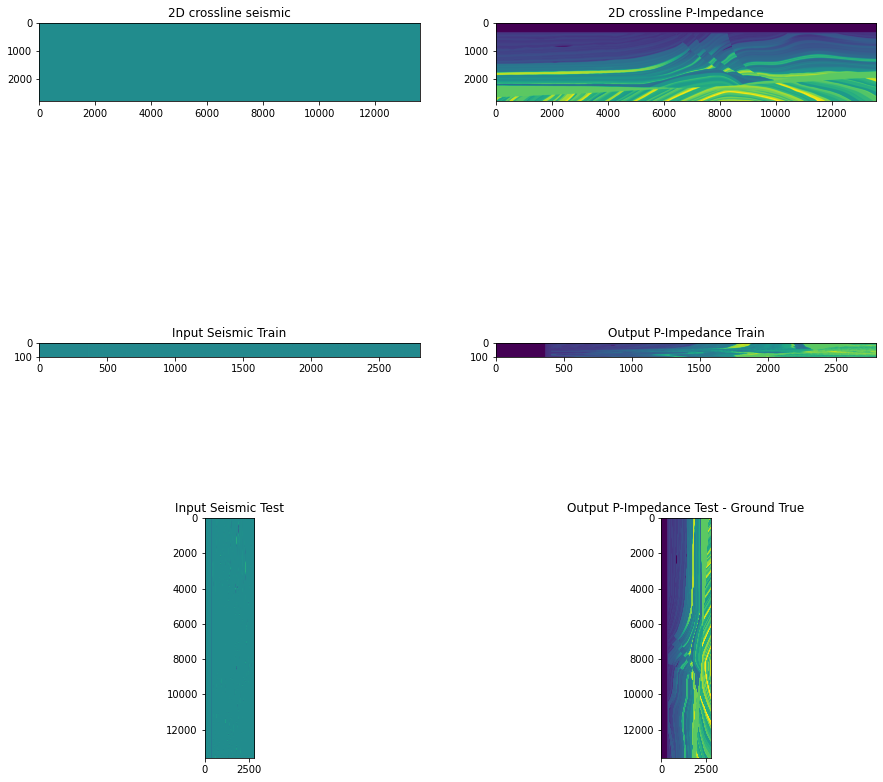

In [11]:
fig1, axes1 = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

axes1[0,0].imshow(seismic)
axes1[0,0].set_title("2D crossline seismic")

axes1[0,1].imshow(pimpedance)
axes1[0,1].set_title("2D crossline P-Impedance")

axes1[1,0].imshow(X_train[:,:,0,0])
axes1[1,0].set_title("Input Seismic Train")

axes1[1,1].imshow(Y_train[:,:,0,0])
axes1[1,1].set_title("Output P-Impedance Train")

axes1[2,0].imshow(X_test[:,:,0,0])
axes1[2,0].set_title("Input Seismic Test")
axes1[2,1].imshow(Y_test[:,:,0,0])
axes1[2,1].set_title("Output P-Impedance Test - Ground True")

## Create and Train Inversion GAN

### Load Forward Model

In [12]:
# load json and create model
json_file = open('forward_model/modelnorm_2d.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
forward_model = model_from_json(loaded_model_json)
# load weights into new model
forward_model.load_weights("forward_model/modelnorm_2d.h5")
print("Loaded forward model from disk")

Loaded forward model from disk


In [13]:
test_forward = False
if test_forward:
    predict = forward_model(Y_test[:6000,:])
    predict = np.transpose(predict[:,:,0].numpy())

In [14]:
if test_forward:
    trace_id = np.random.randint(predict.shape[1])
    plt.plot(predict[0,:,trace_id])
    plt.plot(X_test[trace_id,:,0])
    plt.show()

### Create the generator


In [15]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,1,1))

    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(noise)
    GEN = layers.BatchNormalization()(noise)
    GEN = layers.ReLU()(GEN)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
        
    GEN = layers.Conv2D(filters=1,kernel_size=(3,1),strides=(1,1),padding='same')(GEN)

    GENmodel = keras.models.Model(inputs=noise,outputs=GEN)
    return GENmodel

### Create the discriminator (the critic in the original WGAN)

In [16]:
def get_discriminator_model():       
    input_disc = layers.Input(shape=IMG_SHAPE)        
    ENC = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same',strides=2)(input_disc)
    ENC = layers.LeakyReLU()(ENC)
    ENC = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENC)
        
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(ENC)
    ENCB1 = layers.ReLU()(ENCB1)
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB1)
    ENCB1 = layers.Add()([ENCB1, ENC])
    ENCB1 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB1)
    ENCB1 = layers.ReLU()(ENCB1)
        
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(ENCB1)
    ENCB2 = layers.ReLU()(ENCB2)
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB2)
    ENCB2 = layers.Add()([ENCB2, ENCB1])
    ENCB2 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB2)
    ENCB2 = layers.ReLU()(ENCB1)
        
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(ENCB2)
    ENCB3 = layers.ReLU()(ENCB3)
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB3)
    ENCB3 = layers.Add()([ENCB2, ENCB3])
    ENCB3 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB3)
    ENCB3 = layers.ReLU()(ENCB3)
        
    r1 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=1)(ENCB3)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.ReLU()(r1)
    r2 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=3)(ENCB3)
    r2 = layers.BatchNormalization()(r2)
    r2 = layers.ReLU()(r2)
    r3 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=5)(ENCB3)
    r3 = layers.BatchNormalization()(r3)
    r3 = layers.ReLU()(r3)
    r4 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=7)(ENCB3)
    r4 = layers.BatchNormalization()(r4)
    r4 = layers.ReLU()(r4)
    assp = layers.concatenate([r1,r2,r3,r4])
    assp = layers.Conv2D(filters=64,kernel_size=(3,1),padding='same',strides=2)(assp)
        
        
    fc_out = layers.Dense(256,kernel_initializer=tf.keras.initializers.HeNormal())(assp)
    lkr_out = layers.LeakyReLU()(fc_out)
    fc2_outFlatten = layers.Flatten()(lkr_out)
    fc2_out = layers.Dense(1,kernel_initializer=tf.keras.initializers.HeNormal())(fc2_outFlatten)
        
    DISCmodel = keras.models.Model(inputs=input_disc,outputs=fc2_out)
    return DISCmodel

In [17]:
d_model = get_discriminator_model()
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2800, 1, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1400, 1, 16)  4816        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1400, 1, 16)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 700, 1, 16)   0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [18]:
g_model = get_generator_model()
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2800, 1, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 2800, 1, 1)   4           input_2[0][0]                    
__________________________________________________________________________________________________
re_lu_10 (ReLU)                 (None, 2800, 1, 1)   0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 2800, 1, 16)  4816        re_lu_10[0][0]                   
____________________________________________________________________________________________

### Create the WGAN-GP models

In [19]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
        alpha_weight = 1000,
        beta_weight = 500
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.alpha_weight = alpha_weight
        self.beta_weight = beta_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, imp_loss_fn, seis_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.imp_loss_fn = imp_loss_fn
        self.seis_loss_fn = seis_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        
        alpha = tf.random.normal([batch_size, 1, 1,1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
       
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        noises_input,real_images = data
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = noises_input
        
        for i in range(self.d_steps):

            with tf.GradientTape() as tape:
                
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)

                real_logits = self.discriminator(real_images, training=True)

                # discriminator loss
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                
                # gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                
                d_loss = d_cost + gp * self.gp_weight 
            
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        # Unlabed seismic mini-batch:
        unlabed_wells_loc = np.arange(UNLABED_SEISMIC.shape[1])
        np.random.shuffle(unlabed_wells_loc)
        unlabed_batch_idxs = unlabed_wells_loc[0:BATCH_SIZE]
        unlabed_batch = UNLABED_SEISMIC[unlabed_batch_idxs,:,:,:]
        
        with tf.GradientTape() as tape:
            
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            
            #Generator loss
            g_cost = self.g_loss_fn(gen_img_logits)
            
            #Impedance loss
            imp_loss = self.imp_loss_fn(generated_images, real_images)
                        
            #Seismic loss:
            fake_seis_unlabed = forward_model(self.generator(unlabed_batch,training=True))
            seis_cost = self.seis_loss_fn(fake_seis_unlabed,unlabed_batch)
            
            g_loss = g_cost + self.alpha_weight * imp_loss + self.beta_weight * seis_cost
            
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss,"imp_loss":(self.alpha_weight * imp_loss),"seis_loss":(self.beta_weight * seis_cost)}

### CallBacks

In [20]:
checkp_callback = keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                             monitor='imp_loss',
                                             verbose=2,
                                             save_best_only=True,
                                             mode='min')

earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='imp_loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=2, 
            patience=600)

nan_callback = tf.keras.callbacks.TerminateOnNaN()

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.d_losses = []
        self.g_losses = []
        self.imp_losses = []
        self.seis_losses =[]
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.d_losses.append(logs.get('d_loss'))
        self.g_losses.append(logs.get('g_loss'))
        self.imp_losses.append(logs.get('imp_loss'))
        self.seis_losses.append(logs.get('seis_loss'))
        self.i += 1
        
        clear_output(wait=True) 
        if self.i>50:
            plt.plot(self.x[-100:], self.d_losses[-100:], label="d_loss")
            plt.plot(self.x[-100:], self.g_losses[-100:], label="g_loss")
            plt.plot(self.x[-100:], self.imp_losses[-100:], label="imp_loss")
            plt.plot(self.x[-100:], self.seis_losses[-100:], label="seis_loss")
        else:
            plt.plot(self.x, self.d_losses, label="d_loss")
            plt.plot(self.x, self.g_losses, label="g_loss")
            plt.plot(self.x, self.imp_losses, label="imp_loss")
            plt.plot(self.x, self.seis_losses, label="seis_loss")
        plt.legend()
        plt.show();
        
plot_callback = PlotLosses()

### Train the end-to-end model

In [21]:
#Initialize internal models: 
g_model = get_generator_model()
d_model = get_discriminator_model()

#optimizers:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = keras.optimizers.Adam(learning_rate = 0.001)

# All needed losses:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def impedance_loss(fake_imp,real_imp):
    imp_mse = tf.keras.metrics.mean_squared_error(real_imp, fake_imp)
    return imp_mse

def seismic_loss(fake_seis,real_seis):
    seis_loss = tf.keras.metrics.mean_squared_error(real_seis, fake_seis)
    return seis_loss


wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
    alpha_weight = 1000,
    beta_weight = 500,
    gp_weight = 10
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    imp_loss_fn = impedance_loss,
    seis_loss_fn = seismic_loss
)

In [22]:
# Initialize model training:
wgan_history = wgan.fit(X_train,
                        Y_train,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        epochs=N_EPOCHS,
                        verbose = 1,
                        #callbacks=[checkp_callback]
                       )

Epoch 1/2000
11/11 [==============================] - 34s 389ms/step - d_loss: -122.5513 - g_loss: 2370.4050 - imp_loss: 2244.2102 - seis_loss: 17.2448
Epoch 2/2000
11/11 [==============================] - 3s 309ms/step - d_loss: -24.1833 - g_loss: 235.9413 - imp_loss: 172.7710 - seis_loss: 1.7079
Epoch 3/2000
11/11 [==============================] - 3s 309ms/step - d_loss: 85.8384 - g_loss: 136.5342 - imp_loss: 106.9195 - seis_loss: 0.7944
Epoch 4/2000
11/11 [==============================] - 3s 315ms/step - d_loss: -21.4569 - g_loss: 103.4532 - imp_loss: 75.0756 - seis_loss: 0.5866
Epoch 5/2000
11/11 [==============================] - 3s 312ms/step - d_loss: -14.8413 - g_loss: 64.5488 - imp_loss: 57.7787 - seis_loss: 0.4278
Epoch 6/2000
11/11 [==============================] - 3s 309ms/step - d_loss: -15.9780 - g_loss: 72.7289 - imp_loss: 52.9562 - seis_loss: 0.3947
Epoch 7/2000
11/11 [==============================] - 3s 309ms/step - d_loss: -25.2327 - g_loss: 81.0300 - imp_loss: 50

In [23]:
X_predict = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predict.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predict.shape[0]:
        start_ = X_predict.shape[0]
    if stop_ >= X_predict.shape[0]:
        stop_ = X_predict.shape[0]    
        
    X_predict[start_:stop_,:] = wgan.generator(X_test[start_:stop_,:,:,:])[:,:,0,0]
X_predict = np.transpose(X_predict)

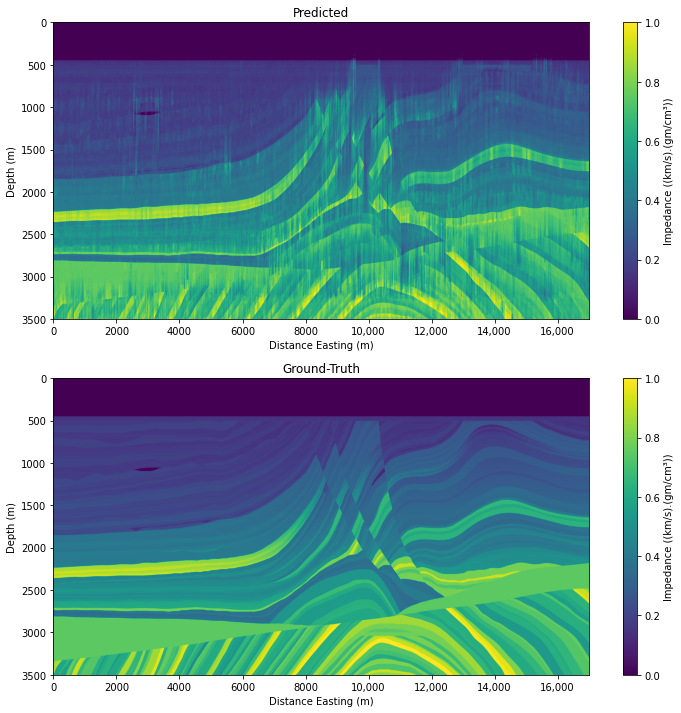

In [24]:
vmin, vmax = np.transpose(Y_test[:,:,0,0]).min(), np.transpose(Y_test[:,:,0,0]).max()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
imcolor = ax1.imshow(X_predict, vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax1, label="Impedance ((km/s).(gm/cm³))")
ax1.set_aspect('auto')
ax1.set_xlabel('Distance Easting (m)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Predicted')
ax1.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

ax2.imshow(np.transpose(Y_test[:,:,0,0]), vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax2, label="Impedance ((km/s).(gm/cm³))")
ax2.set_aspect('auto')
ax2.set_xlabel('Distance Easting (m)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Ground-Truth')
ax2.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

plt.show()

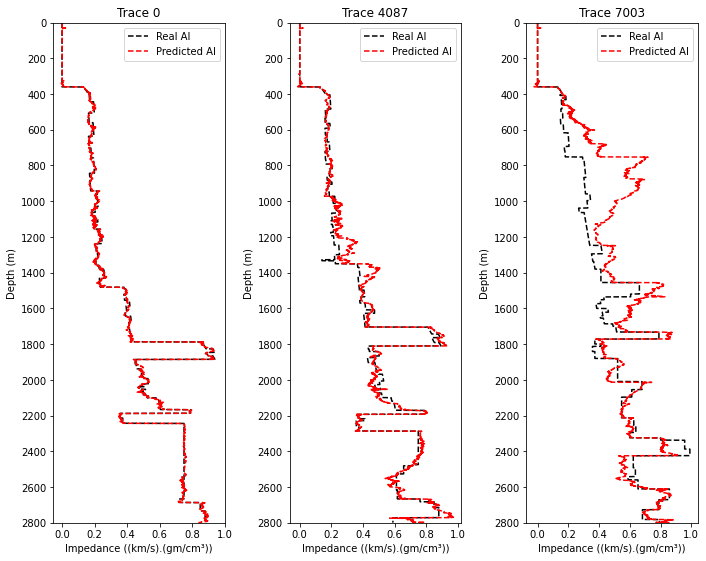

In [25]:
test_imp = Y_test[:,:,0,0].T

n = 3
plt.figure(figsize=(10, 15))
plot_traces = [0, 4087, 7003]
trace_size = len(test_imp[:, plot_traces[0]])
ip_end = test_imp[:, plot_traces[0]].max()
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.tight_layout()
    ax.set_title("Trace {0}".format(plot_traces[i - 1]))
    plt.plot(test_imp[:, plot_traces[i-1]], range(trace_size), '--k')
    plt.plot(X_predict[:, plot_traces[i-1]], range(trace_size), '--r')
    plt.legend(['Real AI', 'Predicted AI'])
    plt.ylabel("Depth (m)")
    plt.xlabel("Impedance ((km/s).(gm/cm³))")
    ax.set_ylim(0, trace_size)
    ax.set_xticks(np.arange(0, ip_end+0.1, 0.2))
    ax.set_yticks(np.arange(0, trace_size+1, 200))
    ax.invert_yaxis()
plt.show()

In [26]:
from sklearn.metrics import r2_score

AI_pred_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
AI_act_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
for i in range(len(traces_marmousi2_test)):
    AI_pred_partial[i] = X_predict.transpose()[traces_marmousi2_test[i]]
    AI_act_partial[i] = Y_test[traces_marmousi2_test[i],:,0,0]
    
print('r^2 score: {:0.4f}'.format(r2_score(AI_act_partial.T, AI_pred_partial.T)))
print('MSE: {:0.4f}'.format(np.sum((AI_pred_partial-AI_act_partial).ravel()**2)/AI_pred_partial.size))
print('MAE: {:0.4f}'.format(np.sum(np.abs(AI_pred_partial - AI_act_partial)/AI_pred_partial.size)))
print('MedAE: {:0.4f}'.format(np.median(np.abs(AI_pred_partial - AI_act_partial))))

AI_pred = X_predict.transpose()
AI_act = Y_test[:,:,0,0]

original_shape = np.expand_dims(AI_pred, axis=2)
    
pred_image = np.expand_dims(AI_pred, axis=2)
pred_image = (pred_image - np.min(pred_image)) / (np.max(pred_image) - np.min(pred_image))
pred_image = pred_image.reshape(original_shape.shape)
pred_image = (pred_image).astype('float32')
    
act_image = np.expand_dims(AI_act, axis=2)
act_image = (act_image - np.min(act_image)) / (np.max(act_image) - np.min(act_image))
act_image = act_image.reshape(original_shape.shape)
act_image = (act_image).astype('float32')
    
ssim = tf.image.ssim(act_image, pred_image, max_val=1).numpy()
print('SSIM: {:0.4f}'.format(ssim))

r^2 score: 0.9286
MSE: 0.0048
MAE: 0.0397
MedAE: 0.0183
SSIM: 0.7079


## Train baseline: CNN = generator

In [27]:
cnn_inversion = get_generator_model()
cnn_inversion.summary()

optimizer_cnn = keras.optimizers.Adam(learning_rate = 0.001)

cnn_inversion.compile(optimizer=optimizer_cnn, loss='mse', metrics='mse')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2800, 1, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 2800, 1, 1)   4           input_5[0][0]                    
__________________________________________________________________________________________________
re_lu_34 (ReLU)                 (None, 2800, 1, 1)   0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 2800, 1, 16)  4816        re_lu_34[0][0]                   
____________________________________________________________________________________________

In [29]:
gcnn_history = cnn_inversion.fit(X_train,Y_train,
                                 validation_data=(X_valid,Y_valid),
                                 epochs=N_EPOCHS,
                                 verbose=1,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE,
                                 #callbacks = [plot_losses]
                                )

Epoch 1/2000
11/11 [==============================] - 2s 129ms/step - loss: 2.1445 - mse: 2.1445 - val_loss: 0.2512 - val_mse: 0.2512
Epoch 2/2000
11/11 [==============================] - 1s 103ms/step - loss: 0.0891 - mse: 0.0891 - val_loss: 0.2594 - val_mse: 0.2594
Epoch 3/2000
11/11 [==============================] - 1s 103ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.3096 - val_mse: 0.3096
Epoch 4/2000
11/11 [==============================] - 1s 103ms/step - loss: 0.0457 - mse: 0.0457 - val_loss: 0.3776 - val_mse: 0.3776
Epoch 5/2000
11/11 [==============================] - 1s 103ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.4411 - val_mse: 0.4411
Epoch 6/2000
11/11 [==============================] - 1s 105ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.5135 - val_mse: 0.5135
Epoch 7/2000
11/11 [==============================] - 1s 106ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.5728 - val_mse: 0.5728
Epoch 8/2000
11/11 [==============================] - 1s 103ms

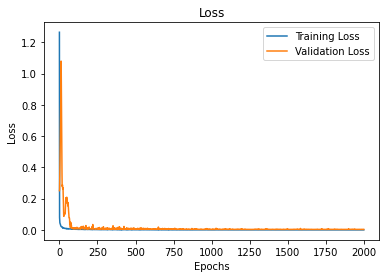

In [30]:
plt.plot(gcnn_history.history['loss'])
plt.plot(gcnn_history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [31]:
X_predictCNN = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predictCNN.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predictCNN.shape[0]:
        start_ = X_predictCNN.shape[0]
    if stop_ >= X_predictCNN.shape[0]:
        stop_ = X_predictCNN.shape[0]    
        
    X_predictCNN[start_:stop_,:] = cnn_inversion(X_test[start_:stop_,:,:,:])[:,:,0,0]
X_predictCNN = np.transpose(X_predictCNN)

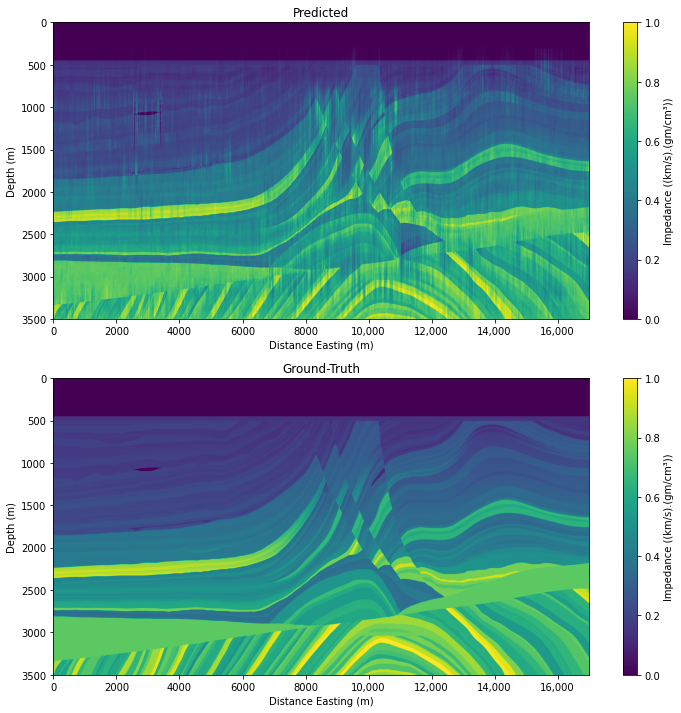

In [32]:
vmin, vmax = np.transpose(Y_test[:,:,0,0]).min(), np.transpose(Y_test[:,:,0,0]).max()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
imcolor = ax1.imshow(X_predictCNN, vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax1, label="Impedance ((km/s).(gm/cm³))")
ax1.set_aspect('auto')
ax1.set_xlabel('Distance Easting (m)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Predicted')
ax1.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

ax2.imshow(np.transpose(Y_test[:,:,0,0]), vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax2, label="Impedance ((km/s).(gm/cm³))")
ax2.set_aspect('auto')
ax2.set_xlabel('Distance Easting (m)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Ground-Truth')
ax2.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

plt.show()

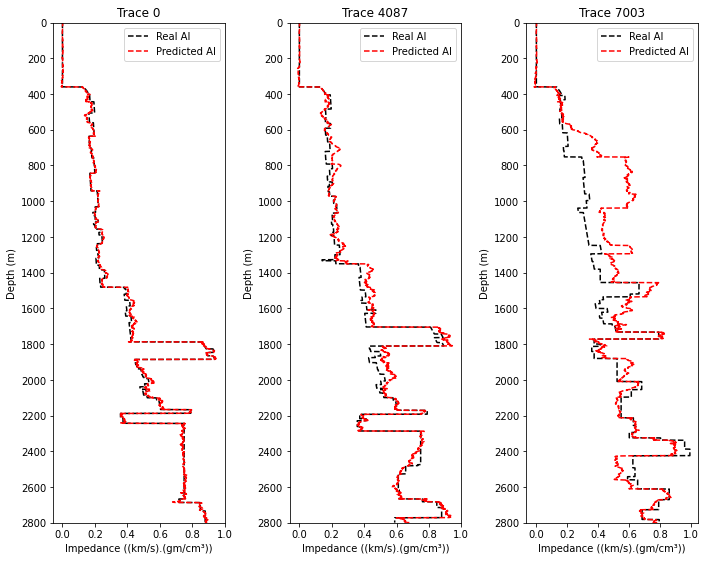

In [33]:
test_imp = Y_test[:,:,0,0].T

n = 3
plt.figure(figsize=(10, 15))
plot_traces = [0, 4087, 7003]
trace_size = len(test_imp[:, plot_traces[0]])
ip_end = test_imp[:, plot_traces[0]].max()
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.tight_layout()
    ax.set_title("Trace {0}".format(plot_traces[i - 1]))
    plt.plot(test_imp[:, plot_traces[i-1]], range(trace_size), '--k')
    plt.plot(X_predictCNN[:, plot_traces[i-1]], range(trace_size), '--r')
    plt.legend(['Real AI', 'Predicted AI'])
    plt.ylabel("Depth (m)")
    plt.xlabel("Impedance ((km/s).(gm/cm³))")
    ax.set_ylim(0, trace_size)
    ax.set_xticks(np.arange(0, ip_end+0.1, 0.2))
    ax.set_yticks(np.arange(0, trace_size+1, 200))
    ax.invert_yaxis()
plt.show()

In [34]:
from sklearn.metrics import r2_score

AI_pred_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
AI_act_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
for i in range(len(traces_marmousi2_test)):
    AI_pred_partial[i] = X_predictCNN.transpose()[traces_marmousi2_test[i]]
    AI_act_partial[i] = Y_test[traces_marmousi2_test[i],:,0,0]
    
print('r^2 score: {:0.4f}'.format(r2_score(AI_act_partial.T, AI_pred_partial.T)))
print('MSE: {:0.4f}'.format(np.sum((AI_pred_partial-AI_act_partial).ravel()**2)/AI_pred_partial.size))
print('MAE: {:0.4f}'.format(np.sum(np.abs(AI_pred_partial - AI_act_partial)/AI_pred_partial.size)))
print('MedAE: {:0.4f}'.format(np.median(np.abs(AI_pred_partial - AI_act_partial))))

AI_pred = X_predictCNN.transpose()
AI_act = Y_test[:,:,0,0]

original_shape = np.expand_dims(AI_pred, axis=2)
    
pred_image = np.expand_dims(AI_pred, axis=2)
pred_image = (pred_image - np.min(pred_image)) / (np.max(pred_image) - np.min(pred_image))
pred_image = pred_image.reshape(original_shape.shape)
pred_image = (pred_image).astype('float32')
    
act_image = np.expand_dims(AI_act, axis=2)
act_image = (act_image - np.min(act_image)) / (np.max(act_image) - np.min(act_image))
act_image = act_image.reshape(original_shape.shape)
act_image = (act_image).astype('float32')
    
ssim = tf.image.ssim(act_image, pred_image, max_val=1).numpy()
print('SSIM: {:0.4f}'.format(ssim))

r^2 score: 0.9503
MSE: 0.0033
MAE: 0.0352
MedAE: 0.0200
SSIM: 0.7648


# Train the same networks with Noisy Seismic

In [35]:
X_train_wNoise = X_train.copy()
X_valid_wNoise = X_valid.copy()
X_test_wNoise = X_test.copy()

noise_rate = 20

for it in range(X_train_wNoise.shape[0]):
    data_i = X_train_wNoise[it,:,0,0]
    noise_i = np.convolve(np.random.normal(size=(data_i.shape[0],)), WAVELET[:,0], mode='same')
    noise_i = noise_i/np.std(noise_i)
    noise_i = noise_i*np.std(data_i)/np.sqrt(noise_rate)
    
    data_i = data_i + noise_i
    X_train_wNoise[it,:,0,0] = data_i
    
for it in range(X_valid_wNoise.shape[0]):
    data_i = X_valid_wNoise[it,:,0,0]
    noise_i = np.convolve(np.random.normal(size=(data_i.shape[0],)), WAVELET[:,0], mode='same')
    noise_i = noise_i/np.std(noise_i)
    noise_i = noise_i*np.std(data_i)/np.sqrt(noise_rate)
    
    data_i = data_i + noise_i
    X_valid_wNoise[it,:,0,0] = data_i

for it in range(X_test_wNoise.shape[0]):
    data_i = X_test_wNoise[it,:,0,0]
    noise_i = np.convolve(np.random.normal(size=(data_i.shape[0],)), WAVELET[:,0], mode='same')
    noise_i = noise_i/np.std(noise_i)
    noise_i = noise_i*np.std(data_i)/np.sqrt(noise_rate)
    
    data_i = data_i + noise_i
    X_test_wNoise[it,:,0,0] = data_i

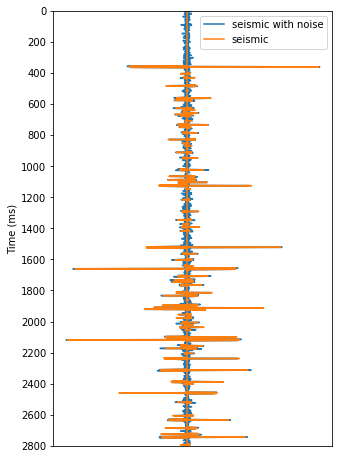

In [36]:
trace_id = np.random.randint(X_train.shape[0])

size_wm = len(X_train_wNoise[trace_id,:,0,0])
size_xt = len(X_train[trace_id,:,0,0])

fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(111)

ax.plot(X_train_wNoise[trace_id,:,0,0], range(size_wm))
ax.plot(X_train[trace_id,:,0,0], range(size_xt))
ax.legend(('seismic with noise','seismic'))
ax.set_ylabel("Time (ms)")
ax.set_ylim(0, size_wm)
ax.set_yticks(np.arange(0, size_wm+1, 200))
ax.get_xaxis().set_visible(False)
ax.invert_yaxis()

### WGAN-GP with Noisy Seismic

In [37]:
# Initialize Callbacks
plot_losses_wnoise = PlotLosses()
checkp_callback_wnoise = keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                             monitor='imp_loss',
                                             verbose=2,
                                             save_best_only=True,
                                             mode='min')

In [38]:
#Initialize internal models: 
g_model_wnoise = get_generator_model()
d_model_wnoise = get_discriminator_model()

#optimizers:
generator_optimizer_wnoise = keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer_wnoise = keras.optimizers.Adam(learning_rate = 0.001)

# All needed losses:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def impedance_loss(fake_imp,real_imp):
    imp_mse = tf.keras.metrics.mean_squared_error(real_imp, fake_imp)
    return imp_mse

def seismic_loss(fake_seis,real_seis):
    seis_loss = tf.keras.metrics.mean_squared_error(real_seis, fake_seis)
    return seis_loss

wgan_wnoise = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
    alpha_weight = 1000,
    beta_weight = 500,
    gp_weight = 10
)

wgan_wnoise.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    imp_loss_fn = impedance_loss,
    seis_loss_fn = seismic_loss
)

In [39]:
wgan_noise_history = wgan_wnoise.fit(X_train_wNoise,
                                     Y_train,
                                     shuffle=True,
                                     batch_size=BATCH_SIZE,
                                     epochs=N_EPOCHS,
                                     verbose = 1,
                                     #callbacks=[checkp_callback_wnoise]
                                    )

Epoch 1/2000
11/11 [==============================] - 18s 309ms/step - d_loss: 0.0284 - g_loss: -30.5294 - imp_loss: 3.2664 - seis_loss: 0.0906
Epoch 2/2000
11/11 [==============================] - 3s 312ms/step - d_loss: 0.0153 - g_loss: -19.2567 - imp_loss: 2.3717 - seis_loss: 0.0872
Epoch 3/2000
11/11 [==============================] - 3s 314ms/step - d_loss: -2.1362e-04 - g_loss: -50.3962 - imp_loss: 2.0002 - seis_loss: 0.1028
Epoch 4/2000
11/11 [==============================] - 3s 312ms/step - d_loss: 0.0388 - g_loss: -79.1667 - imp_loss: 1.4976 - seis_loss: 0.0687
Epoch 5/2000
11/11 [==============================] - 3s 316ms/step - d_loss: -0.1944 - g_loss: -9.4101 - imp_loss: 1.1182 - seis_loss: 0.0599
Epoch 6/2000
11/11 [==============================] - 3s 314ms/step - d_loss: -0.1810 - g_loss: 1.4865 - imp_loss: 1.4768 - seis_loss: 0.0574
Epoch 7/2000
11/11 [==============================] - 3s 313ms/step - d_loss: -0.1837 - g_loss: 38.6726 - imp_loss: 1.6846 - seis_loss: 0

In [40]:
X_predict_wnoise = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predict_wnoise.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predict_wnoise.shape[0]:
        start_ = X_predict_wnoise.shape[0]
    if stop_ >= X_predict_wnoise.shape[0]:
        stop_ = X_predict_wnoise.shape[0]    
        
    X_predict_wnoise[start_:stop_,:] = wgan_wnoise.generator(X_test_wNoise[start_:stop_,:,:,:])[:,:,0,0]
X_predict_wnoise = np.transpose(X_predict_wnoise)

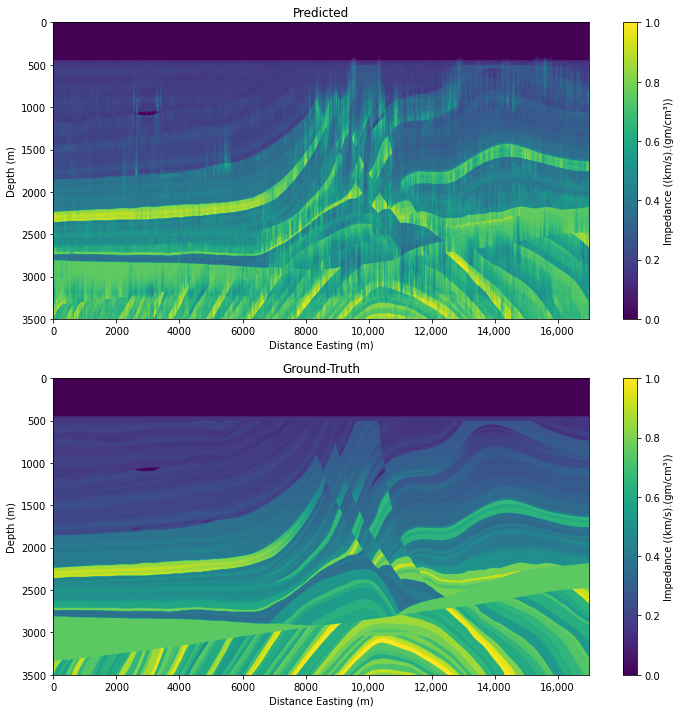

In [41]:
vmin, vmax = np.transpose(Y_test[:,:,0,0]).min(), np.transpose(Y_test[:,:,0,0]).max()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
imcolor = ax1.imshow(X_predict_wnoise, vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax1, label="Impedance ((km/s).(gm/cm³))")
ax1.set_aspect('auto')
ax1.set_xlabel('Distance Easting (m)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Predicted')
ax1.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

ax2.imshow(np.transpose(Y_test[:,:,0,0]), vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax2, label="Impedance ((km/s).(gm/cm³))")
ax2.set_aspect('auto')
ax2.set_xlabel('Distance Easting (m)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Ground-Truth')
ax2.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

plt.show()

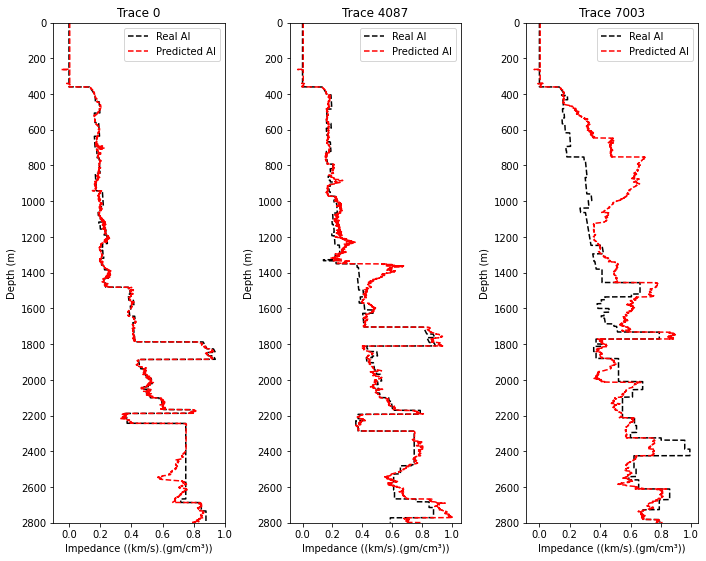

In [42]:
test_imp = Y_test[:,:,0,0].T

n = 3
plt.figure(figsize=(10, 15))
plot_traces = [0, 4087, 7003]
trace_size = len(test_imp[:, plot_traces[0]])
ip_end = test_imp[:, plot_traces[0]].max()
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.tight_layout()
    ax.set_title("Trace {0}".format(plot_traces[i - 1]))
    plt.plot(test_imp[:, plot_traces[i-1]], range(trace_size), '--k')
    plt.plot(X_predict_wnoise[:, plot_traces[i-1]], range(trace_size), '--r')
    plt.legend(['Real AI', 'Predicted AI'])
    plt.ylabel("Depth (m)")
    plt.xlabel("Impedance ((km/s).(gm/cm³))")
    ax.set_ylim(0, trace_size)
    ax.set_xticks(np.arange(0, ip_end+0.1, 0.2))
    ax.set_yticks(np.arange(0, trace_size+1, 200))
    ax.invert_yaxis()
plt.show()

In [43]:
from sklearn.metrics import r2_score

AI_pred_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
AI_act_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
for i in range(len(traces_marmousi2_test)):
    AI_pred_partial[i] = X_predict_wnoise.transpose()[traces_marmousi2_test[i]]
    AI_act_partial[i] = Y_test[traces_marmousi2_test[i],:,0,0]
    
print('r^2 score: {:0.4f}'.format(r2_score(AI_act_partial.T, AI_pred_partial.T)))
print('MSE: {:0.4f}'.format(np.sum((AI_pred_partial-AI_act_partial).ravel()**2)/AI_pred_partial.size))
print('MAE: {:0.4f}'.format(np.sum(np.abs(AI_pred_partial - AI_act_partial)/AI_pred_partial.size)))
print('MedAE: {:0.4f}'.format(np.median(np.abs(AI_pred_partial - AI_act_partial))))

AI_pred = X_predict_wnoise.transpose()
AI_act = Y_test[:,:,0,0]

original_shape = np.expand_dims(AI_pred, axis=2)
    
pred_image = np.expand_dims(AI_pred, axis=2)
pred_image = (pred_image - np.min(pred_image)) / (np.max(pred_image) - np.min(pred_image))
pred_image = pred_image.reshape(original_shape.shape)
pred_image = (pred_image).astype('float32')
    
act_image = np.expand_dims(AI_act, axis=2)
act_image = (act_image - np.min(act_image)) / (np.max(act_image) - np.min(act_image))
act_image = act_image.reshape(original_shape.shape)
act_image = (act_image).astype('float32')
    
ssim = tf.image.ssim(act_image, pred_image, max_val=1).numpy()
print('SSIM: {:0.4f}'.format(ssim))

r^2 score: 0.9210
MSE: 0.0053
MAE: 0.0426
MedAE: 0.0191
SSIM: 0.6419


### CNN Inversion with Noisy Seismic

In [44]:
cnn_inversion_wnoise = get_generator_model()
optimizer_cnn_wnoise = keras.optimizers.Adam(learning_rate = 0.001)

cnn_inversion_wnoise.compile(optimizer=optimizer_cnn_wnoise,
                             loss='mse',
                             metrics='mse'
                            )
gcnn_noise_history = cnn_inversion_wnoise.fit(X_train_wNoise,
                                              Y_train,
                                              validation_data=(X_valid_wNoise,
                                                               Y_valid
                                                              ),
                                              epochs=N_EPOCHS,
                                              verbose=1,
                                              shuffle=True,
                                              batch_size=BATCH_SIZE,
                                              #callbacks = [plot_losses]
                                             )

Epoch 1/2000
11/11 [==============================] - 2s 119ms/step - loss: 5.1169 - mse: 5.1169 - val_loss: 0.5760 - val_mse: 0.5760
Epoch 2/2000
11/11 [==============================] - 1s 99ms/step - loss: 0.1236 - mse: 0.1236 - val_loss: 1.9341 - val_mse: 1.9341
Epoch 3/2000
11/11 [==============================] - 1s 102ms/step - loss: 0.0877 - mse: 0.0877 - val_loss: 2.3640 - val_mse: 2.3640
Epoch 4/2000
11/11 [==============================] - 1s 102ms/step - loss: 0.0693 - mse: 0.0693 - val_loss: 1.1664 - val_mse: 1.1664
Epoch 5/2000
11/11 [==============================] - 1s 100ms/step - loss: 0.0565 - mse: 0.0565 - val_loss: 1.3096 - val_mse: 1.3096
Epoch 6/2000
11/11 [==============================] - 1s 102ms/step - loss: 0.0544 - mse: 0.0544 - val_loss: 1.4854 - val_mse: 1.4854
Epoch 7/2000
11/11 [==============================] - 1s 100ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 1.6342 - val_mse: 1.6342
Epoch 8/2000
11/11 [==============================] - 1s 102ms/

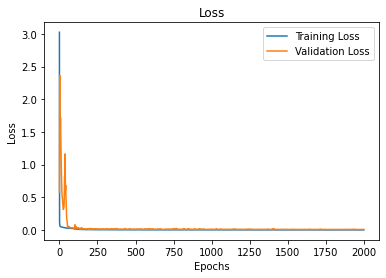

In [45]:
plt.plot(gcnn_noise_history.history['loss'])
plt.plot(gcnn_noise_history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [46]:
X_predictCNN_wnoise = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predictCNN_wnoise.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predictCNN_wnoise.shape[0]:
        start_ = X_predictCNN_wnoise.shape[0]
    if stop_ >= X_predictCNN_wnoise.shape[0]:
        stop_ = X_predictCNN_wnoise.shape[0]    
        
    X_predictCNN_wnoise[start_:stop_,:] = cnn_inversion_wnoise(X_test_wNoise[start_:stop_,:,:,:])[:,:,0,0]
X_predictCNN_wnoise = np.transpose(X_predictCNN_wnoise)   

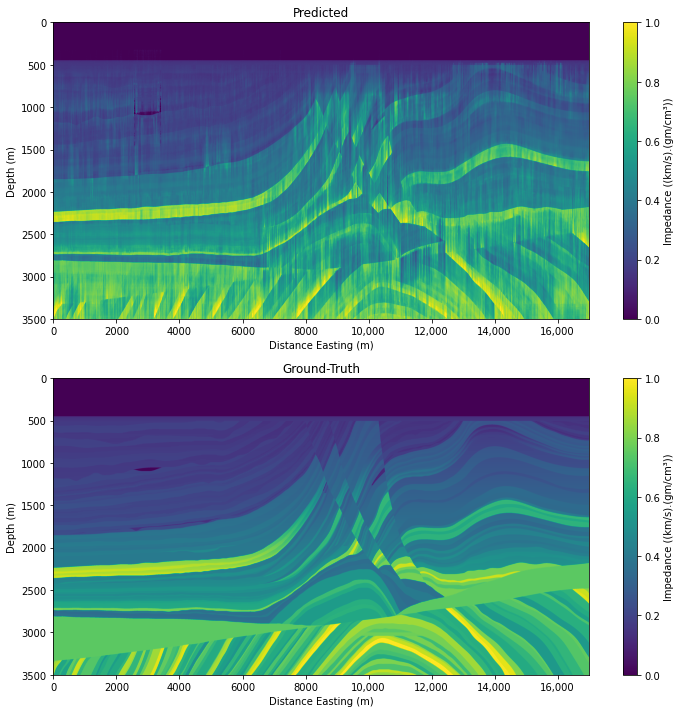

In [47]:
vmin, vmax = np.transpose(Y_test[:,:,0,0]).min(), np.transpose(Y_test[:,:,0,0]).max()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
imcolor = ax1.imshow(X_predictCNN_wnoise, vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax1, label="Impedance ((km/s).(gm/cm³))")
ax1.set_aspect('auto')
ax1.set_xlabel('Distance Easting (m)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Predicted')
ax1.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

ax2.imshow(np.transpose(Y_test[:,:,0,0]), vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax2, label="Impedance ((km/s).(gm/cm³))")
ax2.set_aspect('auto')
ax2.set_xlabel('Distance Easting (m)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Ground-Truth')
ax2.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

plt.show()

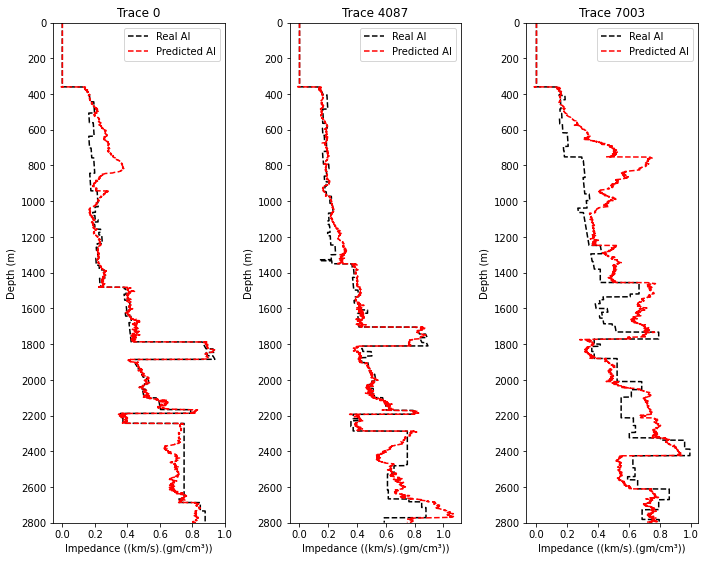

In [48]:
test_imp = Y_test[:,:,0,0].T

n = 3
plt.figure(figsize=(10, 15))
plot_traces = [0, 4087, 7003]
trace_size = len(test_imp[:, plot_traces[0]])
ip_end = test_imp[:, plot_traces[0]].max()
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.tight_layout()
    ax.set_title("Trace {0}".format(plot_traces[i - 1]))
    plt.plot(test_imp[:, plot_traces[i-1]], range(trace_size), '--k')
    plt.plot(X_predictCNN_wnoise[:, plot_traces[i-1]], range(trace_size), '--r')
    plt.legend(['Real AI', 'Predicted AI'])
    plt.ylabel("Depth (m)")
    plt.xlabel("Impedance ((km/s).(gm/cm³))")
    ax.set_ylim(0, trace_size)
    ax.set_xticks(np.arange(0, ip_end+0.1, 0.2))
    ax.set_yticks(np.arange(0, trace_size+1, 200))
    ax.invert_yaxis()
plt.show()

In [49]:
from sklearn.metrics import r2_score

AI_pred_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
AI_act_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
for i in range(len(traces_marmousi2_test)):
    AI_pred_partial[i] = X_predictCNN_wnoise.transpose()[traces_marmousi2_test[i]]
    AI_act_partial[i] = Y_test[traces_marmousi2_test[i],:,0,0]
    
print('r^2 score: {:0.4f}'.format(r2_score(AI_act_partial.T, AI_pred_partial.T)))
print('MSE: {:0.4f}'.format(np.sum((AI_pred_partial-AI_act_partial).ravel()**2)/AI_pred_partial.size))
print('MAE: {:0.4f}'.format(np.sum(np.abs(AI_pred_partial - AI_act_partial)/AI_pred_partial.size)))
print('MedAE: {:0.4f}'.format(np.median(np.abs(AI_pred_partial - AI_act_partial))))

AI_pred = X_predictCNN_wnoise.transpose()
AI_act = Y_test[:,:,0,0]

original_shape = np.expand_dims(AI_pred, axis=2)
    
pred_image = np.expand_dims(AI_pred, axis=2)
pred_image = (pred_image - np.min(pred_image)) / (np.max(pred_image) - np.min(pred_image))
pred_image = pred_image.reshape(original_shape.shape)
pred_image = (pred_image).astype('float32')
    
act_image = np.expand_dims(AI_act, axis=2)
act_image = (act_image - np.min(act_image)) / (np.max(act_image) - np.min(act_image))
act_image = act_image.reshape(original_shape.shape)
act_image = (act_image).astype('float32')
    
ssim = tf.image.ssim(act_image, pred_image, max_val=1).numpy()
print('SSIM: {:0.4f}'.format(ssim))

r^2 score: 0.8869
MSE: 0.0076
MAE: 0.0550
MedAE: 0.0308
SSIM: 0.5773
